In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import datasets, linear_model
from sklearn.preprocessing import scale 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

# Remove print limit
pd.set_option("display.max_columns", None)

In [42]:
crab_data = pd.read_csv("/Users/brittonstoakes/airflow-test/data/crab_output.csv")

In [43]:
crab_data.head()

,latitude,longitude,crab_year,crab_name,maturity,bottom_depth,surface_temperature,bottom_temperature,crab_haul
0,57.33959,-164.00767,1980,hair crab,Total female,60,3.2,1.5,28
1,57.33675,-160.91067,1980,hair crab,Total female,64,1.7,1.4,55
2,57.33583,-168.94117,1980,hair crab,Total female,71,5.7,3.4,103
3,57.33400,-170.21267,1980,hair crab,Total female,53,5.3,5.1,60
4,55.34417,-163.42834,1980,hair crab,Total female,51,NaN,NaN,42


In [44]:
crab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2801 entries, 0 to 2800
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latitude             2801 non-null   float64
 1   longitude            2801 non-null   float64
 2   crab_year            2801 non-null   int64  
 3   crab_name            2801 non-null   object 
 4   maturity             2801 non-null   object 
 5   bottom_depth         2801 non-null   int64  
 6   surface_temperature  2756 non-null   float64
 7   bottom_temperature   2681 non-null   float64
 8   crab_haul            2801 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 197.1+ KB


In [45]:
crab_data.describe()


,latitude,longitude,crab_year,bottom_depth,surface_temperature,bottom_temperature,crab_haul
count,2801.000000,2801.000000,2801.000000,2801.000000,2756.000000,2681.000000,2801.000000
mean,57.828332,-166.682748,1999.630846,61.562299,5.481023,2.398881,76.789004
std,1.244222,3.571028,11.522250,17.447507,2.184813,1.713312,42.917122
min,54.657500,-175.824840,1980.000000,25.000000,-0.100000,-1.700000,1.000000
25%,56.999890,-169.361960,1990.000000,50.000000,4.000000,1.300000,31.000000
50%,57.500130,-167.999010,2000.000000,61.000000,5.400000,2.500000,87.000000
75%,58.669720,-162.831750,2010.000000,70.000000,7.100000,3.600000,108.000000
max,62.004700,-158.396360,2018.000000,157.000000,12.400000,7.600000,217.000000


In [46]:
crab_data.isnull().sum()

latitude                 0
longitude                0
crab_year                0
crab_name                0
maturity                 0
bottom_depth             0
surface_temperature     45
bottom_temperature     120
crab_haul                0
dtype: int64

In [47]:
crab_data = crab_data.fillna(crab_data.median())

In [48]:
def perc_on_bar(z):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''

    total = len(crab_data[z]) # Length of the column
    
    plt.figure(figsize = (15, 5))
    
    ax = sns.countplot(crab_data[z], palette = 'Paired', order = crab_data[z].value_counts().index)
    
    for p in ax.patches:
        
        percentage = '{:.1f}%'.format(100 * p.get_height() / total) # Percentage of each class of the category
        
        x = p.get_x() + p.get_width() / 2 - 0.05 # Width of the plot
        
        y = p.get_y() + p.get_height()           # Hieght of the plot
        
        ax.annotate(percentage, (x, y), size = 12) # Annotate the percantage 
    
    plt.show() # Show the plot

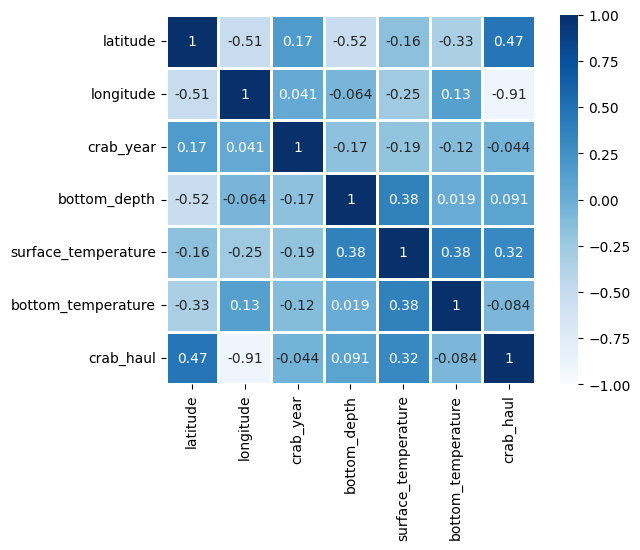

In [49]:
df = crab_data
corr = df.corr()

axl = sns.heatmap(corr, cbar=1, annot=True, linewidths=2,vmax=1, vmin=-1, square=True, cmap='Blues')
plt.show()


Prepping Data For Training

In [50]:
crab_data.head(1)

,latitude,longitude,crab_year,crab_name,maturity,bottom_depth,surface_temperature,bottom_temperature,crab_haul
0,57.33959,-164.00767,1980,hair crab,Total female,60,3.2,1.5,28


In [51]:
X = crab_data[["latitude", "longitude", "crab_year", "crab_name", "maturity", "bottom_depth", "surface_temperature", "bottom_temperature"]]

Y = crab_data[["crab_haul"]]

In [52]:
Xx = pd.get_dummies(X, drop_first=True)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(Xx, Y, test_size = 0.30, random_state = 1)

In [54]:
print(X_train.shape, X_test.shape)

(1960, 7) (841, 7)


In [55]:
# Writing a function for calculating r2_score and RMSE on train and test data
# This function takes model as an input on which we have trained particular algorithm
# The categorical column as the input and returns the boxplots and histograms for the variable

def get_model_score(model, flag = True):
    '''
    model : regressor to predict values of X

    '''
    # Defining an empty list to store train and test results
    score_list = []
    
    pred_train = model.predict(X_train)
   
    pred_train_ = np.exp(pred_train)
    
    pred_test = model.predict(X_test)
    
    pred_test_ = np.exp(pred_test)
    
    train_r2 = metrics.r2_score(y_train['crab_haul'], pred_train_)
    
    test_r2 = metrics.r2_score(y_test['crab_haul'], pred_test_)
    
    train_rmse = metrics.mean_squared_error(y_train['crab_haul'], pred_train_, squared = False)
    
    test_rmse = metrics.mean_squared_error(y_test['crab_haul'], pred_test_, squared = False)
    
    # Adding all scores in the list
    score_list.extend((train_r2, test_r2, train_rmse, test_rmse))
    
    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag == True: 
        
        print("R-square on training set : ", metrics.r2_score(y_train['crab_haul'], pred_train_))
        
        print("R-square on test set : ", metrics.r2_score(y_test['crab_haul'], pred_test_))
        
        print("RMSE on training set : ", np.sqrt(metrics.mean_squared_error(y_train['crab_haul'], pred_train_)))
        
        print("RMSE on test set : ", np.sqrt(metrics.mean_squared_error(y_test['crab_haul'], pred_test_)))
    
    # Returning the list with train and test scores
    return score_list

Linear Regression 

In [56]:
#linear regression model
lr = linear_model.LinearRegression()

In [57]:
#Fitting data
lr.fit(X_train, y_train['crab_haul'])

LinearRegression()

In [58]:
# Get score of the model
LR_score = get_model_score(lr)

R-square on training set :  -4.929116810524822e+157
R-square on test set :  -5.967745883273142e+140
RMSE on training set :  2.99881299540737e+80
RMSE on test set :  1.0583542222404728e+72


Ordinary Least Squares 

In [59]:
# Statsmodel api does not add a constant by default. We need to add it explicitly
x_train = sm.add_constant(X_train)

# Add constant to test data
x_test = sm.add_constant(X_test)

def build_ols_model(train):
    
    # Create the model
    olsmodel = sm.OLS(y_train["crab_haul"], train)
    
    return olsmodel.fit()


# Fit linear model on new dataset
olsmodel1 = build_ols_model(x_train)

print(olsmodel1.summary())

olsmodel1.mse_resid

                            OLS Regression Results                            
Dep. Variable:              crab_haul   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1493.
Date:                Fri, 06 Jan 2023   Prob (F-statistic):               0.00
Time:                        12:24:48   Log-Likelihood:                -8328.1
No. Observations:                1960   AIC:                         1.667e+04
Df Residuals:                    1952   BIC:                         1.672e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1841.5236    

288.3846160890172